# Getting started with *AxonDeepSeg*

*AxonDeepSeg* is a software that allows you to segment both axon and myelin sheaths from various microscopy modalities. The algorithm is based on convolutional neural networks. 

In this Jupyter notebook, the following steps are listed:

**(0)** - Import the necessary librairies.<br>
**(1)** - Define the inputs and parameters for the segmentation (test image, model).<br>
**(2)** - Launch the segmentation on the test image.<br>
**(3)** - Display the result (axon/myelin mask).<br>
**(4)** - Validate the segmentation output against the gold standard using the Dice similarity coefficient.<br>

#### Before getting started, kindly have look AxonDeepSeg documentation(https://axondeepseg.readthedocs.io/en/latest/documentation.html#getting-started) to correctly install AxonDeepSeg.

# 0) Imports

First of all, we are going to import some standard libraries. 

In [11]:
%matplotlib inline

In [12]:
import json
import os
import matplotlib.pyplot as plt
from AxonDeepSeg.testing.segmentation_scoring import *
import AxonDeepSeg.ads_utils as ads
from time import time

# 1) Define the parameters to use for the segmentation

Here, we are going to specify the input parameters to use for the segmentation.

**1.1. Set the path of the test image to segment.**

We first need to specify the path to the directory containing the image that we want to segment. The standard directory structure for *AxonDeepSeg* contains: (i) the image file to segment (**'image.png'**), (ii) the gold standard mask of the segmentation to validate our result (**'mask.png'**) and (iii) a *txt* file that contains the pixel size of the image in micrometers (**'pixel_size_in_micrometer.txt'**).

In [13]:
path_testing = os.path.join('..','AxonDeepSeg','models','default_SEM_model','data_test')

**1.2. Select the trained model you want to use for the segmentation.**

Here, we specify the deep learning model we want to use in order to segment our sample. We currently propose 2 models: one for scanning electron microscopy (SEM) samples, and a second for transmission electron microscopy (TEM) samples. The current versions of the models are **'default_SEM_model'** and **'default_TEM_model'**, respectively. In this case, our test sample is a SEM spinal cord sample of the rat, so we select the SEM model available.

In [14]:
model_name = 'default_SEM_model'

**1.3. Set the path of the segmentation model.**

Here, we specify the path of the directory containing our models.

In [15]:
path_model = os.path.join('..','AxonDeepSeg','models',model_name)

**1.4. Read the parameters of the selected model.**

In *AxonDeepSeg*, each trained model has a corresponding *json* file named **'config_network.json'**. This file documents all the parameters of the model, such as the number of convolutional layers, the number of features per convolutional layer, the dropout and the number of classes. The json file is a good way to keep track of the similarities and differences between the trained models available.

In [16]:
path_configfile = os.path.join(path_model,'config_network.json')

if not os.path.exists(path_model):
    os.makedirs(path_model)

with open(path_configfile, 'r') as fd:
    config_network = json.loads(fd.read())

# 2) Apply the model to segment an image

**2.1. Import the function that performs the segmentation from AxonDeepSeg.**

The function *axon_segmentation* in the **'apply_model.py'** script computes the axon/myelin segmentation of a sample.

In [17]:
from AxonDeepSeg.apply_model import axon_segmentation

**2.2. Launch the segmentation of the image.**

Here, we launch the segmentation. Here, we specify the following inputs in the *axon_segmentation* function: (i) the path of the image, (ii) the name of the image, (iii) the path of the model, (iv) the configuration json file of the model (v) the target resolution (resampled_resolutions) and (vi) the verbosity level. The target resolution of the current version of the models are 0.1 for the **'default_SEM_model'** and 0.01 for the **'default_TEM_model'**. In this case, our test sample is a SEM spinal cord sample of the rat, so we set resampled_resolutions to 0.1. Note that more parameters are available (see description of the *axon_segmentation* function in the code repository).

The output here will be the predicted image, which consists of a 3-label mask (background=0, myelin=127, axon=255). By default, the output prediction will be saved in the same directory as the input image, and named **'image_seg-axonmyelin.png'**.

In [18]:
prediction = axon_segmentation([path_testing], ["image.png"], path_model, config_network, resampled_resolutions=0.1, verbosity_level=3)

Loading acquisitions ...
Rescaling acquisitions to the target resolution ...
Graph construction ...
Beginning inference ...
processing patch 1 of 8
processing patch 2 of 8
processing patch 3 of 8
processing patch 4 of 8
processing patch 5 of 8
processing patch 6 of 8
processing patch 7 of 8
processing patch 8 of 8
_seg-axonmyelin.png


# 3) Display the segmentation result

**3.1. Import sample image and segmentation result.**

In [19]:
imorg = ads.imread(os.path.join(path_testing,'image.png'))
imads = ads.imread(os.path.join(path_testing,'image_seg-axonmyelin.png'))

**3.2. Display sample image.**

Here, we display the original microscopy image.

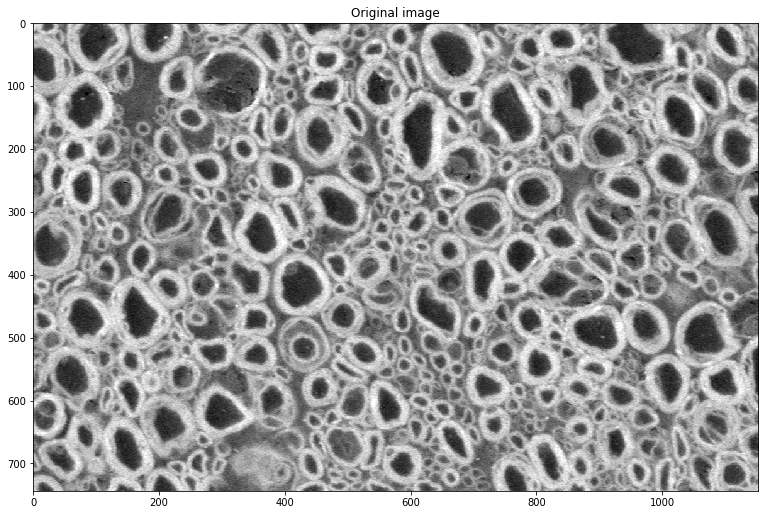

In [20]:
plt.figure(figsize=(13,10))
plt.title('Original image')
plt.imshow(imorg, cmap='gray')
plt.show();

**3.3. Display segmentation result.**

Here, we display the predicted segmentation. Axons are displayed in yellow, while myelin sheaths are displayed in green.

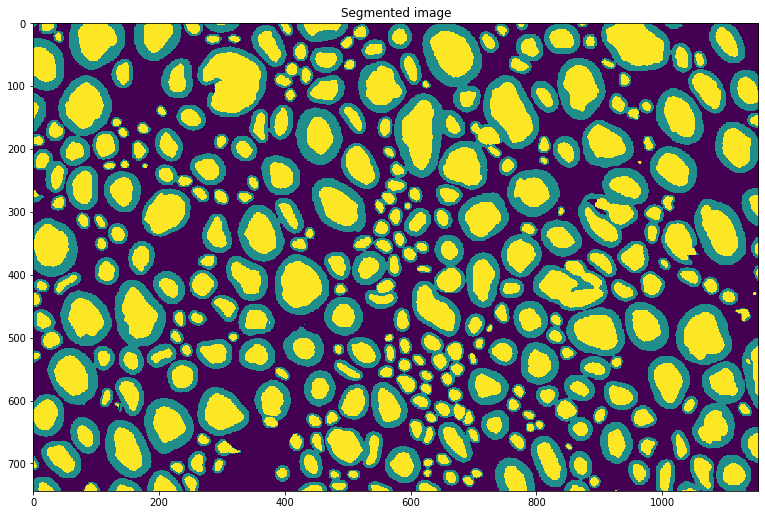

In [21]:
plt.figure(figsize=(13,10))
plt.title('Segmented image')
plt.imshow(imads)
plt.show();

**3.4. Display the segmentation result overlaid on the sample image.**

Here, we overlay the segmentation mask on the original microscopy image to qualitatively evaluate the performance of the segmentation.

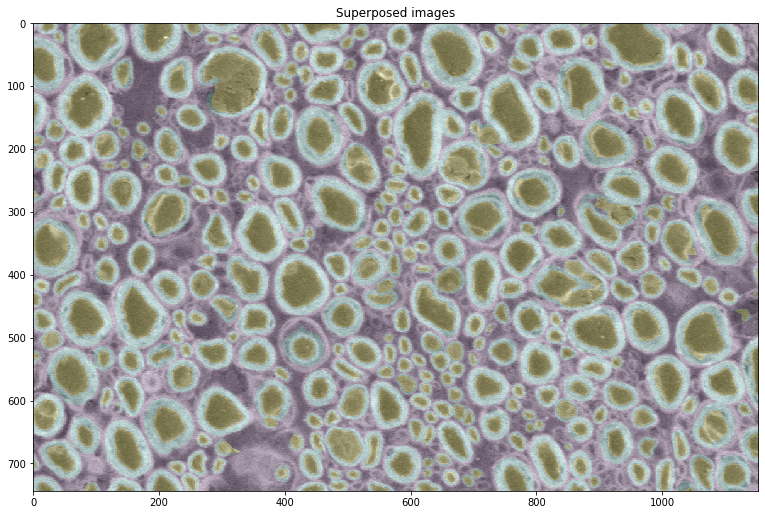

In [22]:
plt.figure(figsize=(13,10))
plt.title('Superposed images')
plt.imshow(imorg, cmap='gray', alpha=0.8)
plt.imshow(imads, cmap='viridis', alpha=0.2)

# 4) Validation of segmentation

**4.1. Import the segmentation result and the gold standard mask.**

In [23]:
mask = ads.imread(os.path.join(path_testing,'mask.png'))
pred = ads.imread(os.path.join(path_testing,'image_seg-axonmyelin.png'))

**4.2. Get the axon and myelin masks from the 3-label masks.**

Here, we extract the binary axon and myelin masks from the 3-class predicted mask.

In [24]:
gt_axon = mask > 200
gt_myelin = np.logical_and(mask >= 50, mask <= 200)

pred_axon = pred > 200
pred_myelin = np.logical_and(pred >= 50, pred <= 200)

**4.3. Compute the axon and myelin Dice similarity metrics and display the results.**

We are using the Dice similarity coefficient to evaluate the segmentation. The obtained axon mask is compared against the axon gold standard. Similarly, we compare the myelin segmentation mask against the myelin gold standard. A Dice value closer to 1 indicates a higher similarity between the segmentation and the gold standard.

In [25]:
dice_axon = pw_dice(pred_axon, gt_axon)
dice_myelin = pw_dice(pred_myelin, gt_myelin)

print('Dice for Axon : ' + str(dice_axon))
print('Dice for myelin : ' + str(dice_myelin))

Dice for Axon : 0.9257008708884038
Dice for myelin : 0.8366348471824568
